# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [93]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions

In [94]:
include("../src/testfns.jl")
include("../src/kernels.jl")
include("../src/surrogates.jl")

ZeroMeanGP (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

Test Function: GramacyLee


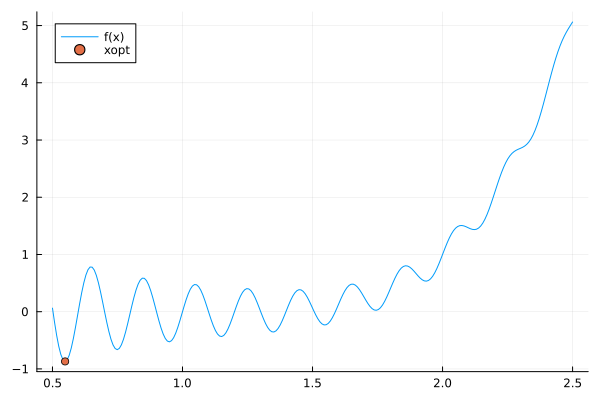

In [95]:
testfn, testfn_name, X, y = get_toy_problem(N=4, fn_name="GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

In [103]:
sur = ZeroMeanGP(SquaredExponential(.25), X, y);

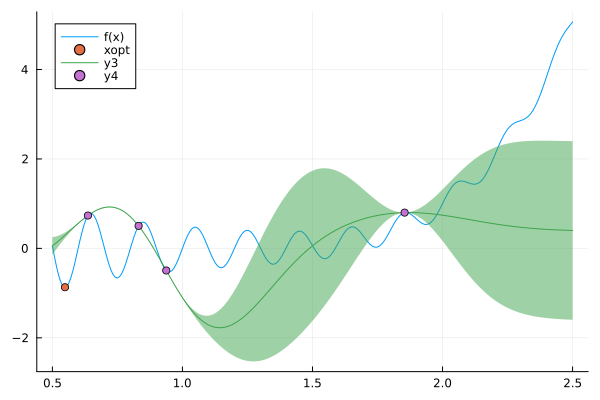

In [104]:
domain = .5:.01:2.5
μ = [first(sur([x])) for x in domain]
σ = [sur([x])[2] for x in domain]
tplot(testfn)
plot!(domain, μ, ribbons=2σ)
scatter!(sur.X', get_observations(sur))

In [99]:
σ

201-element Vector{Float64}:
 2.3301009696385933e-5
 1.78630194902496e-5
 1.3479493110590823e-5
 9.987966794522407e-6
 7.244624051550019e-6
 5.122912240751454e-6
 3.512193864740887e-6
 2.3164366045325124e-6
 1.4529457799117296e-6
 8.511426348167817e-7
 4.5139149729145345e-7
 2.038785593683201e-7
 6.754465842195856e-8
 ⋮
 0.05026644515512224
 0.053146630601820455
 0.05613386698979905
 0.0592294651839298
 0.0624346499221522
 0.0657505568511283
 0.06917822970104126
 0.07271861760613163
 0.07637257257737051
 0.08014084713302427
 0.08402409209270978
 0.08802285453997527

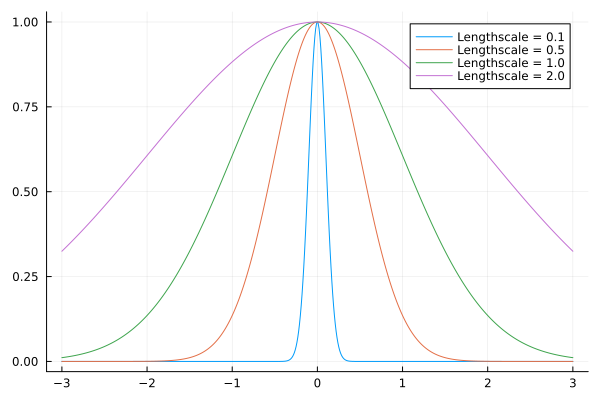

In [21]:
# Let's visualize several different initializations of the squared exponential
# kernel with different lengthscales
lengthscales = [.1, .5, 1., 2.]
kernels = [SquaredExponential(l) for l in lengthscales]
# gram_matrix(SquaredExponential(1.), X, noise=2.)
domain = -3.:.01:3.

plot()
for (i, kernel) in enumerate(kernels)
    plot!(domain, [kernel(x, 0.) for x in domain], label="Lengthscale = $(lengthscales[i])")
end
plot!()